In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [50]:
df = pd.read_csv('Online_Retail.csv', encoding='iso-8859-1')

In [51]:
df.sample(10)

,INVOICE_NO,STOCK_CODE,DESCRIPTION,QUANTITY,INVOICE_DATE,UNIT_PRICE,CUSTOMER_ID,REGION
371379,569219,22730,ALARM CLOCK BAKELIKE IVORY,1,02/10/2020 13:01,3.75,13558.0,United Kingdom
309658,564135,23298,SPOTTY BUNTING,3,23/08/2020 11:12,4.95,16550.0,United Kingdom
89171,543828,21781,MA CAMPAGNE CUTLERY BOX,4,14/02/2020 09:45,14.95,14156.0,EIRE
318637,564837,23174,REGENCY SUGAR BOWL GREEN,1,30/08/2020 12:40,8.29,NaN,United Kingdom
187802,553007,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,72,12/05/2020 16:50,0.85,14000.0,United Kingdom
283722,561798,22729,ALARM CLOCK BAKELIKE ORANGE,4,29/07/2020 13:39,3.75,14911.0,EIRE
424868,573288,48194,DOORMAT HEARTS,10,28/10/2020 14:42,7.08,14194.0,United Kingdom
393586,570834,84879,ASSORTED COLOUR BIRD ORNAMENT,8,12/10/2020 13:31,1.69,13865.0,United Kingdom
121693,546778,22063,CERAMIC BOWL WITH STRAWBERRY DESIGN,2,16/03/2020 16:38,2.95,14572.0,United Kingdom
227506,556879,20781,GOLD EAR MUFF HEADPHONES,1,15/06/2020 12:07,5.49,16461.0,United Kingdom


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   INVOICE_NO    541909 non-null  object 
 1   STOCK_CODE    541909 non-null  object 
 2   DESCRIPTION   540455 non-null  object 
 3   QUANTITY      541909 non-null  int64  
 4   INVOICE_DATE  541909 non-null  object 
 5   UNIT_PRICE    541909 non-null  float64
 6   CUSTOMER_ID   406829 non-null  float64
 7   REGION        541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [53]:
#cambio del nombre de las columnas a minusculas
new_col_name = []

for old_name in df.columns:
    name_stripped = old_name.strip()
    # Luego, pon todas las letras en minúsculas
    name_lowered = name_stripped.lower()
    # Por último, reemplaza los espacios entre palabras por guiones bajos
    name_no_spaces = name_lowered.replace(' ', '_')
    # Agrega el nuevo nombre a la lista de nuevos nombres de columna
    new_col_name.append(name_no_spaces)

df.columns = new_col_name


In [54]:
#cambio de tipo de la columna invoce_date a datetime
df['invoice_date']=pd.to_datetime(df['invoice_date'], format="%d/%m/%Y %H:%M")

In [55]:
#se llenan los nan de la columna customer_id con 0
df['customer_id'] = df['customer_id'].fillna(0)

In [56]:
#cambio del tipo de la columna customer_id a entero
df['customer_id'] = df['customer_id'].astype(int)

In [57]:
df.sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
94119,544330,21181,PLEASE ONE PERSON METAL SIGN,12,2020-02-17 16:59:00,2.10,17576,United Kingdom
364917,568680,23408,PHOTO FRAME LINEN AND LACE SMALL,6,2020-09-28 14:10:00,2.08,18265,United Kingdom
11076,537240,21523,DOORMAT FANCY FONT HOME SWEET HOME,1,2019-12-06 10:08:00,14.43,0,United Kingdom
471539,576644,21928,JUMBO BAG SCANDINAVIAN BLUE PAISLEY,2,2020-11-16 10:01:00,4.13,0,United Kingdom
379045,569672,21972,SET OF 36 DINOSAUR PAPER DOILIES,1,2020-10-05 13:58:00,1.45,17841,United Kingdom
242452,558348,21922,UNION STRIPE WITH FRINGE HAMMOCK,4,2020-06-28 14:50:00,7.95,17188,United Kingdom
11661,537262,82486,WOOD S/3 CABINET ANT WHITE FINISH,2,2019-12-06 11:26:00,7.95,15039,United Kingdom
96069,544476,35961,FOLKART ZINC HEART CHRISTMAS DEC,1,2020-02-21 09:58:00,0.85,14796,United Kingdom
449574,575137,22578,WOODEN STAR CHRISTMAS SCANDINAVIAN,24,2020-11-08 15:13:00,0.29,13090,United Kingdom
498575,578523,84970S,HANGING HEART ZINC T-LIGHT HOLDER,4,2020-11-24 14:10:00,0.85,15311,United Kingdom


In [58]:
df['region'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [59]:
#se remplaza el nombre de los paises agregaqdos como EIRE y RSA para unificar todos los nombres en ingles y mayusculas y minusculas 
df['region']= df['region'].replace('EIRE', 'Ireland')

In [60]:
df['region']= df['region'].replace('RSA', 'Sudafrica')

In [61]:
df['region'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'Ireland', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'Sudafrica'], dtype=object)

In [62]:
#verificacion de los valores menores a cero en la columan quantity. Aun falta determinar que tratamiento se le daran a estos datos 
df[df['quantity'] < 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
141,C536379,D,Discount,-1,2019-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2019-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2019-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2019-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2019-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2020-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2020-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2020-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2020-12-09 11:58:00,1.25,17315,United Kingdom


In [63]:
#verificacion de los valores menores a cero en la columan unit_price. Aun falta determinar que tratamiento se le daran a estos datos 
df[df['unit_price'] < 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
299983,A563186,B,Adjust bad debt,1,2020-08-12 14:51:00,-11062.06,0,United Kingdom
299984,A563187,B,Adjust bad debt,1,2020-08-12 14:52:00,-11062.06,0,United Kingdom


In [64]:
#creacion de una nueva columana que calcula el total vendido por factura 
df['total'] = df['quantity'] * df['unit_price']

In [65]:
#se convierten las descripciones a minuscula para unificar el formato 
df['description'] = df['description'].str.lower()

In [66]:
df.sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total
376219,569518,82494L,wooden frame antique white,3,2020-10-04 14:28:00,2.95,13263,United Kingdom,8.85
225455,556681,20727,lunch bag black skull.,10,2020-06-14 09:41:00,1.65,12826,United Kingdom,16.50
24285,538347,22415,white tissue ream,3,2019-12-10 14:54:00,7.95,17220,United Kingdom,23.85
479321,577155,22151,place setting white heart,24,2020-11-18 09:56:00,0.42,13050,United Kingdom,10.08
150809,549524,22957,set 3 paper vintage chick paper egg,1,2020-04-08 15:42:00,5.79,0,United Kingdom,5.79
433115,573904,23570,traditional pick up sticks game,2,2020-11-01 14:54:00,1.25,14505,United Kingdom,2.50
119888,546635,21912,vintage snakes & ladders,2,2020-03-15 12:11:00,3.75,16392,United Kingdom,7.50
240222,558094,48188,doormat welcome puppies,3,2020-06-26 13:04:00,7.95,14795,United Kingdom,23.85
205495,554814,22469,heart of wicker small,24,2020-05-26 13:34:00,1.65,16609,United Kingdom,39.60
353369,567798,15056N,edwardian parasol natural,6,2020-09-22 12:00:00,5.95,13089,United Kingdom,35.70


In [67]:
#verificar que no existe ningun valor 0 en la columna quantity; sin embargo tener en cuenta que si existen aun menores a 0 
df[df['quantity'] == 0]


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total


In [68]:
#se decide eliminar del dataframe los datos que en unit_price y en customer_id sean iguales a 0, dado que consideramos no aportan ningun informacion util para futuros analisis
ceros = df.query(('unit_price == 0 & customer_id == 0'))
display(ceros)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total
622,536414,22139,NaN,56,2019-12-01 11:52:00,0.0,0,United Kingdom,0.0
1970,536545,21134,NaN,1,2019-12-01 14:32:00,0.0,0,United Kingdom,0.0
1971,536546,22145,NaN,1,2019-12-01 14:33:00,0.0,0,United Kingdom,0.0
1972,536547,37509,NaN,1,2019-12-01 14:33:00,0.0,0,United Kingdom,0.0
1987,536549,85226A,NaN,1,2019-12-01 14:34:00,0.0,0,United Kingdom,0.0
...,...,...,...,...,...,...,...,...,...
536981,581234,72817,NaN,27,2020-12-08 10:33:00,0.0,0,United Kingdom,0.0
538504,581406,46000M,polyester filler pad 45x45cm,240,2020-12-08 13:58:00,0.0,0,United Kingdom,0.0
538505,581406,46000S,polyester filler pad 40x40cm,300,2020-12-08 13:58:00,0.0,0,United Kingdom,0.0
538554,581408,85175,NaN,20,2020-12-08 14:06:00,0.0,0,United Kingdom,0.0


In [69]:
#verificacion relacionado con los datos eliminados 
ceros['description'].unique()

array([nan, 'amazon', '?', 'check', 'damages',
       'cream sweetheart letter rack', 'zinc willie winkie  candle stick',
       'box of 24 cocktail parasols', 'doormat english rose ',
       'doormat 3 smiley cats', 'green regency teacup and saucer',
       'french blue metal door sign 7', 'french blue metal door sign 5',
       'french blue metal door sign 6', 'french blue metal door sign 4',
       'french blue metal door sign no', 'french blue metal door sign 8',
       'french blue metal door sign 1', 'red kitchen scales',
       'ivory kitchen scales', 'set of 6 soldier skittles',
       'childs garden trowel blue ', 'childrens garden gloves blue',
       'picnic basket wicker small', 'picnic basket wicker large',
       'empire union jack tv dinner tray',
       'tv dinner tray vintage paisley', 'spaceboy tv dinner tray',
       'tv dinner tray dolly girl', 'childs garden spade blue',
       'childs garden rake blue', 'watering can pink bunny',
       'enamel fire bucket cream',

In [70]:
#verificacion relacionado con los datos eliminados 
ceros['region'].unique()

array(['United Kingdom', 'Ireland'], dtype=object)

In [71]:
#verificacion relacionado con los datos eliminados 
ceros['invoice_date'].dt.year.unique()


array([2019, 2020], dtype=int32)

In [72]:
#verificacion relacionado con los datos eliminados 
ceros['invoice_date'].dt.month.unique()

array([12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

In [73]:
#se filta el data frame despues de las verificaciones anteriores para conservar unicamente los datos que sean diferentes a 0 
df = df.query(('unit_price != 0 & customer_id != 0'))

In [74]:
df.sample(20)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total
100200,544810,22191,ivory diner wall clock,4,2020-02-23 15:53:00,8.50,17675,United Kingdom,34.00
281691,561595,85099B,jumbo bag red retrospot,10,2020-07-28 11:22:00,2.08,12853,United Kingdom,20.80
211193,555349,21746,small red retrospot windmill,2,2020-06-02 12:08:00,1.25,16729,United Kingdom,2.50
495143,578290,22670,french wc sign blue metal,12,2020-11-23 14:07:00,1.25,13644,United Kingdom,15.00
63462,541570,22326,round snack boxes set of4 woodland,96,2020-01-19 12:34:00,2.55,14646,Netherlands,244.80
373648,569338,22683,french blue metal door sign 8,20,2020-10-03 14:18:00,1.25,16013,United Kingdom,25.00
400492,571313,22061,large cake stand hanging strawbery,8,2020-10-17 10:42:00,9.95,14156,Ireland,79.60
158471,550296,22677,french blue metal door sign 2,1,2020-04-15 15:54:00,1.25,13742,United Kingdom,1.25
122478,546875,21165,beware of the cat metal sign,12,2020-03-17 16:38:00,1.69,12514,Italy,20.28
23656,538208,22749,feltcraft princess charlotte doll,1,2019-12-10 11:39:00,3.75,14037,United Kingdom,3.75


In [75]:
#se verificaron los posibles datos duplicados en todas las columanas posibles y concluimos que los duplicados existentes son coherentes. No se elimina ninguno
df['stock_code'].duplicated().sum()

403105

In [76]:
df.describe()


,quantity,invoice_date,unit_price,customer_id,total
count,406789.000000,406789,406789.000000,406789.000000,406789.000000
mean,12.028359,2020-07-10 12:24:04.519295744,3.460811,15287.795830,20.403860
min,-80995.000000,2019-12-01 08:26:00,0.001000,12346.000000,-168469.600000
25%,2.000000,2020-04-06 15:02:00,1.250000,13954.000000,4.200000
50%,5.000000,2020-07-31 11:46:00,1.950000,15152.000000,11.100000
75%,12.000000,2020-10-20 13:06:00,3.750000,16791.000000,19.500000
max,80995.000000,2020-12-09 12:50:00,38970.000000,18287.000000,168469.600000
std,247.927842,NaN,69.318561,1713.573064,427.612692


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406789 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    406789 non-null  object        
 1   stock_code    406789 non-null  object        
 2   description   406789 non-null  object        
 3   quantity      406789 non-null  int64         
 4   invoice_date  406789 non-null  datetime64[ns]
 5   unit_price    406789 non-null  float64       
 6   customer_id   406789 non-null  int64         
 7   region        406789 non-null  object        
 8   total         406789 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 31.0+ MB


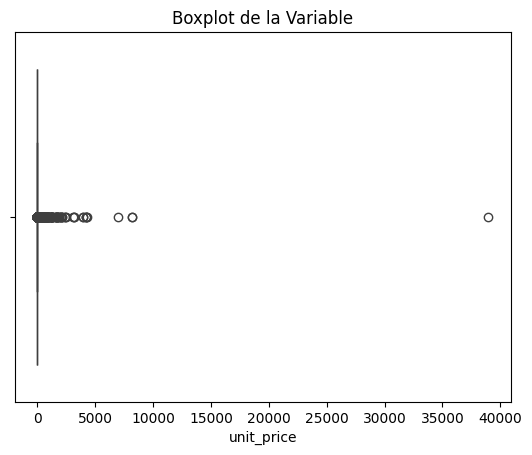

In [78]:
# Graficar un boxplot para identificar valores atípicos
sns.boxplot(x=df['unit_price'])
plt.title('Boxplot de la Variable')
plt.show()

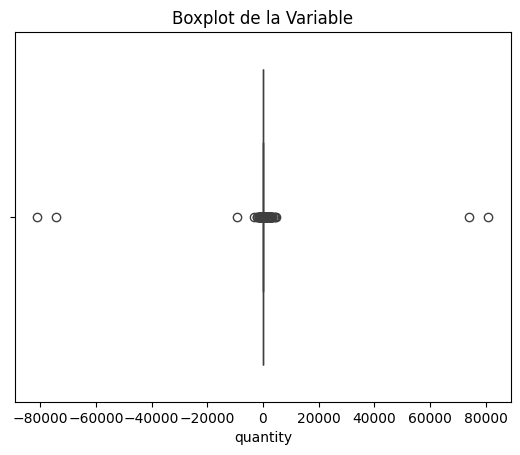

In [79]:
# Graficar un boxplot para identificar valores atípicos
sns.boxplot(x=df['quantity'])
plt.title('Boxplot de la Variable')
plt.show()

In [80]:
def define_limits(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr= q3-q1
    
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    
    for value in df[column]:
        print(f"Los limites inferior y superior son {column,lower, upper}")
        return lower, upper
 

In [81]:
define_limits(df, "quantity")
define_limits(df, "unit_price")

Los limites inferior y superior son ('quantity', -13.0, 27.0)
Los limites inferior y superior son ('unit_price', -2.5, 7.5)


(-2.5, 7.5)

In [82]:
def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    df = df.loc[(df[column] >= lower) & (df[column] <= upper)]
    return df

In [83]:
df_filtered = df.copy()

for col in ['quantity', 'unit_price']:
    df_filtered = remove_outliers(df_filtered, col)

df_filtered

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total
0,536365,85123A,white hanging heart t-light holder,6,2019-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2019-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2019-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,pack of 20 spaceboy napkins,12,2020-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,children's apron dolly girl,6,2020-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,childrens cutlery dolly girl,4,2020-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,childrens cutlery circus parade,4,2020-12-09 12:50:00,4.15,12680,France,16.60


In [84]:
df_filtered.describe()

,quantity,invoice_date,unit_price,customer_id,total
count,344362.000000,344362,344362.000000,344362.000000,344362.000000
mean,7.279883,2020-07-12 07:56:54.855704064,2.201449,15319.727281,12.399429
min,-13.000000,2019-12-01 08:26:00,0.001000,12347.000000,-81.000000
25%,2.000000,2020-04-08 08:21:00,1.250000,13988.000000,3.750000
50%,5.000000,2020-08-03 11:58:00,1.650000,15235.000000,9.960000
75%,12.000000,2020-10-23 12:28:00,2.950000,16814.000000,17.242500
max,27.000000,2020-12-09 12:50:00,7.500000,18287.000000,178.800000
std,6.880744,NaN,1.548388,1711.427166,13.390375


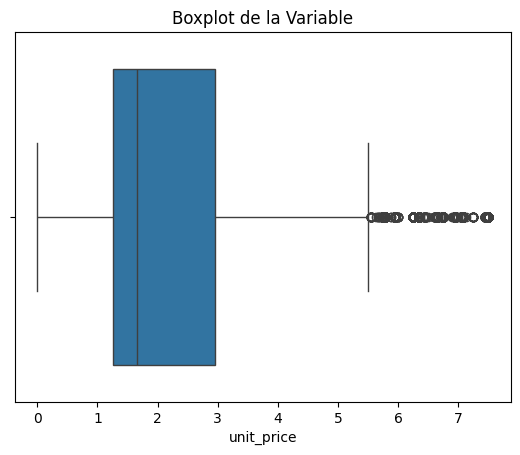

In [85]:
# Graficar un boxplot para identificar valores atípicos
sns.boxplot(x=df_filtered ['unit_price'])
plt.title('Boxplot de la Variable')
plt.show()

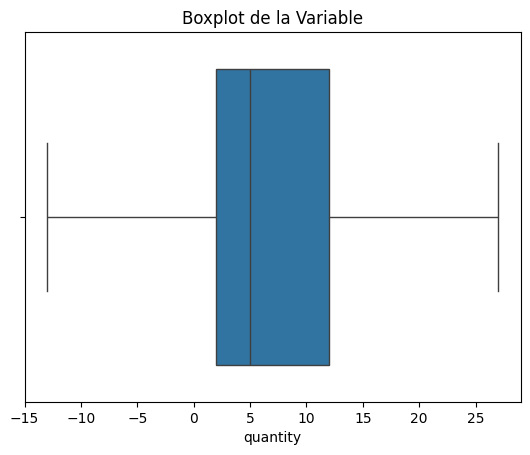

In [86]:
# Graficar un boxplot para identificar valores atípicos
sns.boxplot(x=df_filtered['quantity'])
plt.title('Boxplot de la Variable')
plt.show()

In [87]:

# Persistiendo los cambios
df = df_filtered
df['invoice_date'] = pd.to_datetime(df['invoice_date'])
current_date = datetime.now()

# Calcula Recencia, Frecuencia y Valor Monetario
rfm_df = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (current_date - x.max()).days,
    'total': ['sum', 'count']
})

rfm_df.columns = ['Recency', 'Monetary', 'Frequency']
rfm_df.reset_index(inplace=True)

# Asigna puntuaciones RFM
rfm_df['R_rank'] = pd.qcut(rfm_df['Recency'], 5, labels=False, duplicates='drop') + 1
rfm_df['F_rank'] = pd.qcut(rfm_df['Frequency'], 5, labels=False, duplicates='drop') + 1
rfm_df['M_rank'] = pd.qcut(rfm_df['Monetary'], 5, labels=False, duplicates='drop') + 1

# Puedes combinar las puntuaciones en un código RFM para cada cliente
rfm_df['RFM_Score'] = rfm_df['R_rank'].astype(str) + rfm_df['F_rank'].astype(str) + rfm_df['M_rank'].astype(str)

# Muestra los resultados
print(rfm_df.head())

   customer_id  Recency  Monetary  Frequency  R_rank  F_rank  M_rank RFM_Score
0        12347     1302   3314.73        166       1       5       5       155
1        12348     1548     90.20          6       5       1       1       511
2        12349     1318    999.15         58       2       4       4       244
3        12350     1611    294.40         16       5       2       2       522
4        12352     1336   1010.61         73       3       4       4       344


In [88]:
# Función para asignar segmentos
def segment_customer(row):
    if row['R_rank'] >= 4 and row['F_rank'] >= 4 and row['M_rank'] >= 4:
        return 'Alto_valor'
    elif row['F_rank'] >= 4 and row['M_rank'] >= 4:
        return 'Leal'
    elif row['R_rank'] >= 4 and row['F_rank'] >= 4:
        return 'Potencial'
    elif row['R_rank'] >= 4:
        return 'Mas_Atención'
    elif row['F_rank'] >= 4:
        return 'Oportunidad'
    elif row['R_rank'] >= 4:
        return 'Nuevo'
    elif row['M_rank'] >= 4:
        return 'Alto_Riesgo'
    else:
        return 'Cliente_Perdido'

# Aplica la función de segmentación
rfm_df['Segment'] = rfm_df.apply(segment_customer, axis=1)

# Muestra los resultados
print(rfm_df.head())

   customer_id  Recency  Monetary  Frequency  R_rank  F_rank  M_rank  \
0        12347     1302   3314.73        166       1       5       5   
1        12348     1548     90.20          6       5       1       1   
2        12349     1318    999.15         58       2       4       4   
3        12350     1611    294.40         16       5       2       2   
4        12352     1336   1010.61         73       3       4       4   

  RFM_Score       Segment  
0       155          Leal  
1       511  Mas_Atención  
2       244          Leal  
3       522  Mas_Atención  
4       344          Leal  


In [89]:
# Conteo de clientes por segmento
print(sorted_rfm_df['Segment'].value_counts())

Segment
Mas_Atención       1382
Leal               1170
Cliente_Perdido     961
Oportunidad         212
Alto_Riesgo         202
Alto_valor          189
Potencial           105
Name: count, dtype: int64


/tmp/ipykernel_271/2716284598.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sorted_rfm_df, x='Segment', order=sorted_rfm_df['Segment'].value_counts().index, palette='viridis')


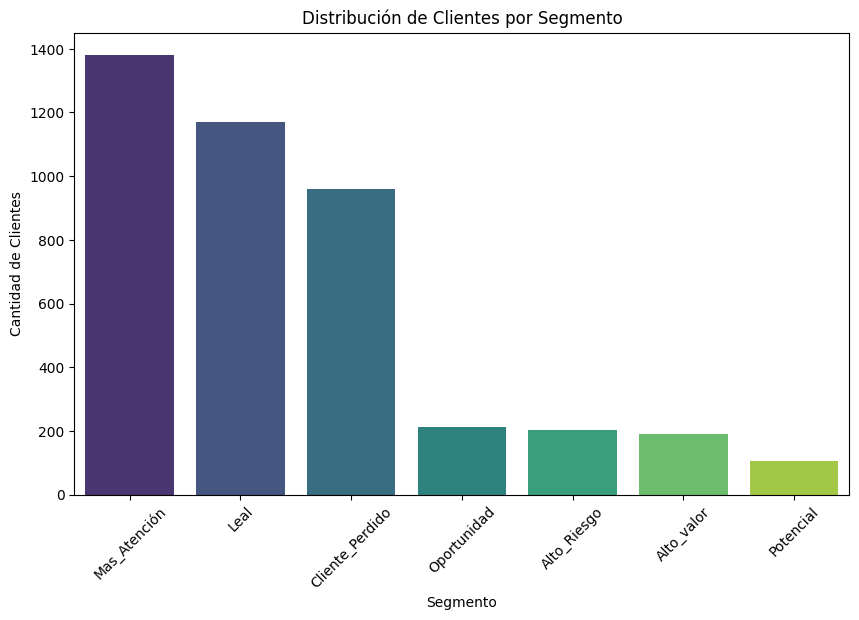

/tmp/ipykernel_271/2716284598.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sorted_rfm_df, x='Segment', y='Recency', palette='viridis', order=sorted_rfm_df['Segment'].value_counts().index)


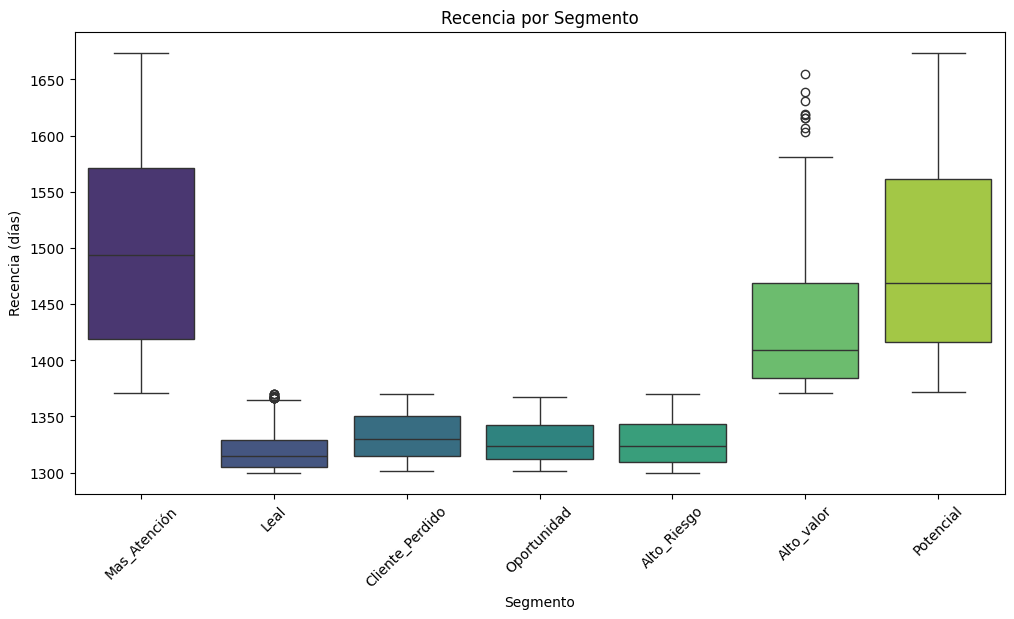

/tmp/ipykernel_271/2716284598.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sorted_rfm_df, x='Segment', y='Frequency', palette='viridis', order=sorted_rfm_df['Segment'].value_counts().index)


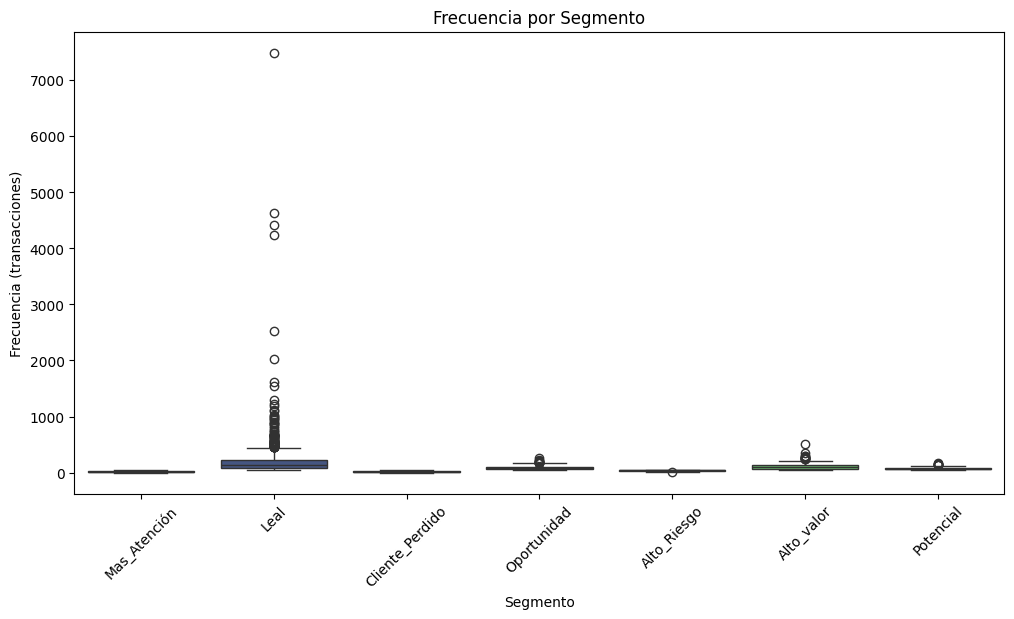

/tmp/ipykernel_271/2716284598.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sorted_rfm_df, x='Segment', y='Monetary', palette='viridis', order=sorted_rfm_df['Segment'].value_counts().index)


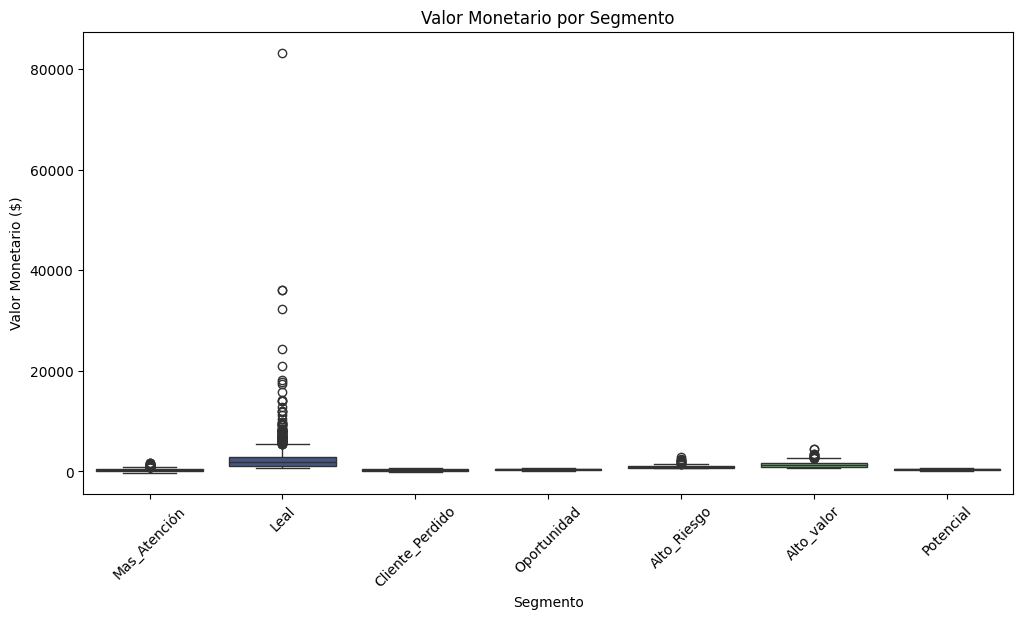

In [90]:
# Gráfico de Barras de la Distribución de Segmentos
plt.figure(figsize=(10, 6))
sns.countplot(data=sorted_rfm_df, x='Segment', order=sorted_rfm_df['Segment'].value_counts().index, palette='viridis')
plt.title('Distribución de Clientes por Segmento')
plt.xlabel('Segmento')
plt.ylabel('Cantidad de Clientes')
plt.xticks(rotation=45)
plt.show()

# Gráfico de Caja y Bigote para Recencia por Segmento
plt.figure(figsize=(12, 6))
sns.boxplot(data=sorted_rfm_df, x='Segment', y='Recency', palette='viridis', order=sorted_rfm_df['Segment'].value_counts().index)
plt.title('Recencia por Segmento')
plt.xlabel('Segmento')
plt.ylabel('Recencia (días)')
plt.xticks(rotation=45)
plt.show()

# Gráfico de Caja y Bigote para Frecuencia por Segmento
plt.figure(figsize=(12, 6))
sns.boxplot(data=sorted_rfm_df, x='Segment', y='Frequency', palette='viridis', order=sorted_rfm_df['Segment'].value_counts().index)
plt.title('Frecuencia por Segmento')
plt.xlabel('Segmento')
plt.ylabel('Frecuencia (transacciones)')
plt.xticks(rotation=45)
plt.show()

# Gráfico de Caja y Bigote para Valor Monetario por Segmento
plt.figure(figsize=(12, 6))
sns.boxplot(data=sorted_rfm_df, x='Segment', y='Monetary', palette='viridis', order=sorted_rfm_df['Segment'].value_counts().index)
plt.title('Valor Monetario por Segmento')
plt.xlabel('Segmento')
plt.ylabel('Valor Monetario ($)')
plt.xticks(rotation=45)
plt.show()

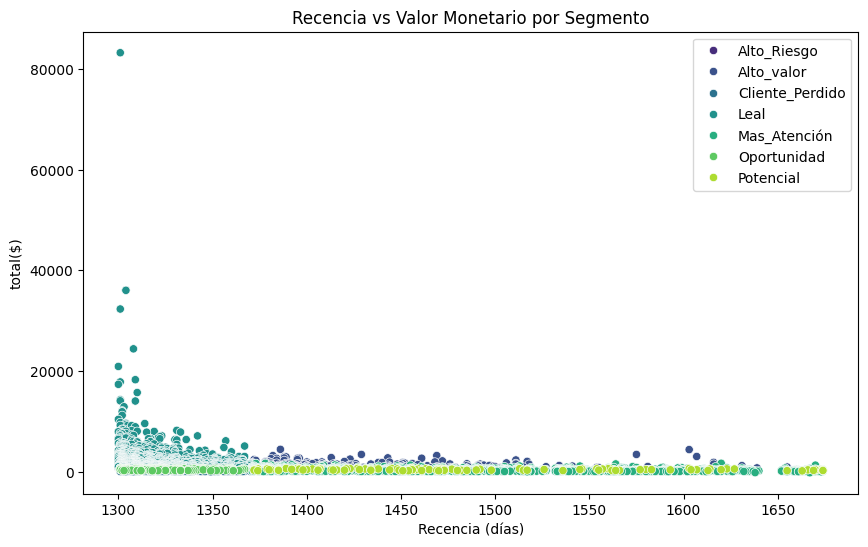

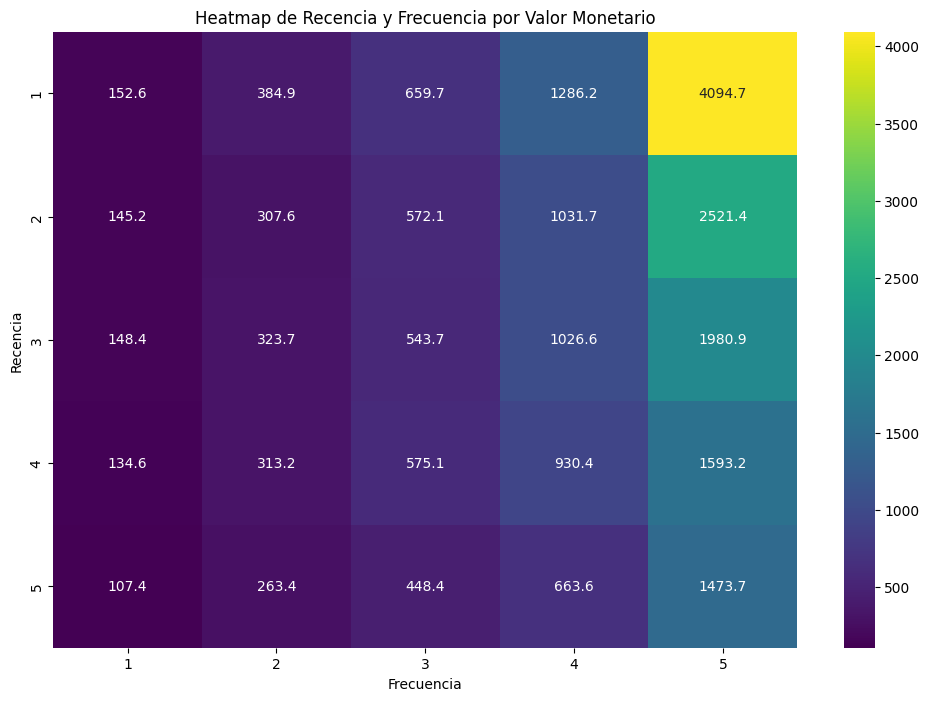

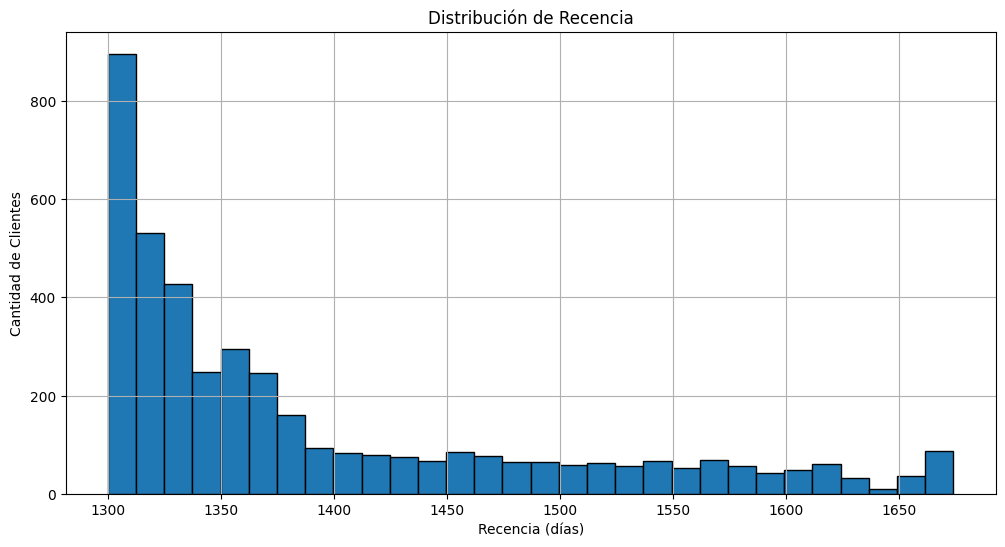

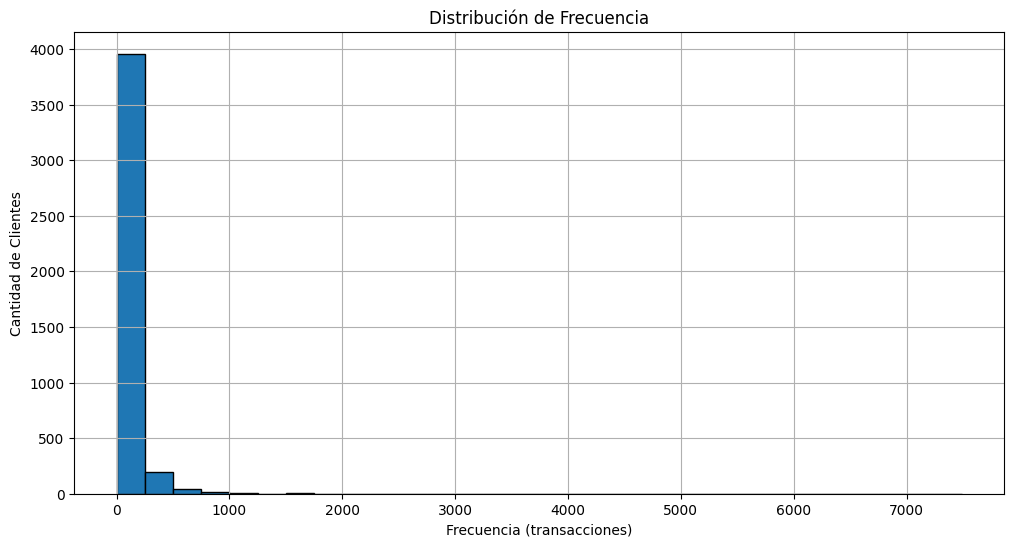

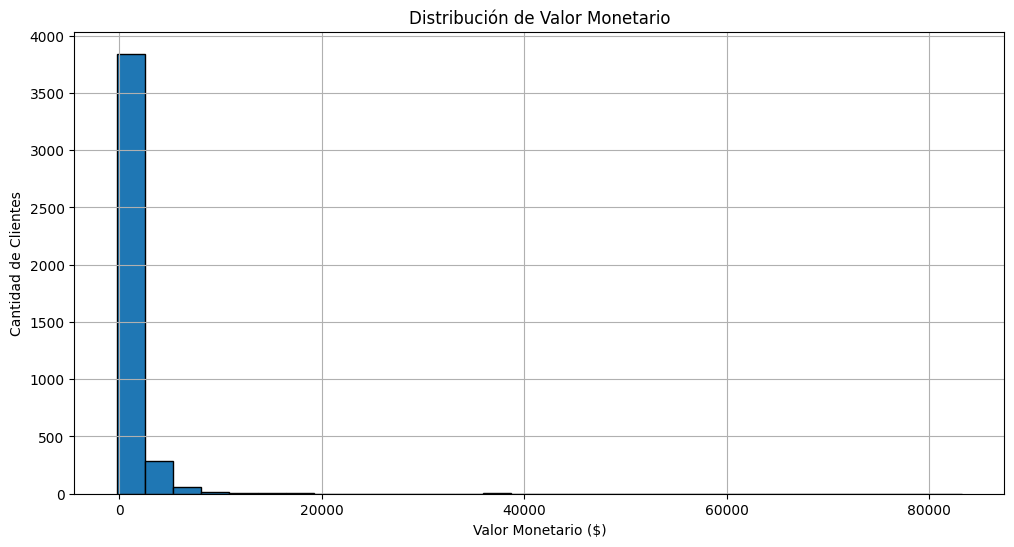

In [91]:
#las graficas anteriores no me dan mucha claridad, veamos otras.

# Gráfico de Dispersión (Recencia vs Valor Monetario)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sorted_rfm_df, x='Recency', y='Monetary', hue='Segment', palette='viridis')
plt.title('Recencia vs Valor Monetario por Segmento')
plt.xlabel('Recencia (días)')
plt.ylabel('total($)')
plt.legend(loc='upper right')
plt.show()

# Heatmap (Relación Recencia y Frecuencia por Segmento)
heatmap_data = sorted_rfm_df.pivot_table(index='R_rank', columns='F_rank', values='Monetary', aggfunc='mean').fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='viridis')
plt.title('Heatmap de Recencia y Frecuencia por Valor Monetario')
plt.xlabel('Frecuencia')
plt.ylabel('Recencia')
plt.show()

# Histogramas
plt.figure(figsize=(12, 6))
sorted_rfm_df['Recency'].hist(bins=30, edgecolor='black')
plt.title('Distribución de Recencia')
plt.xlabel('Recencia (días)')
plt.ylabel('Cantidad de Clientes')
plt.show()

plt.figure(figsize=(12, 6))
sorted_rfm_df['Frequency'].hist(bins=30, edgecolor='black')
plt.title('Distribución de Frecuencia')
plt.xlabel('Frecuencia (transacciones)')
plt.ylabel('Cantidad de Clientes')
plt.show()

plt.figure(figsize=(12, 6))
sorted_rfm_df['Monetary'].hist(bins=30, edgecolor='black')
plt.title('Distribución de Valor Monetario')
plt.xlabel('Valor Monetario ($)')
plt.ylabel('Cantidad de Clientes')
plt.show()


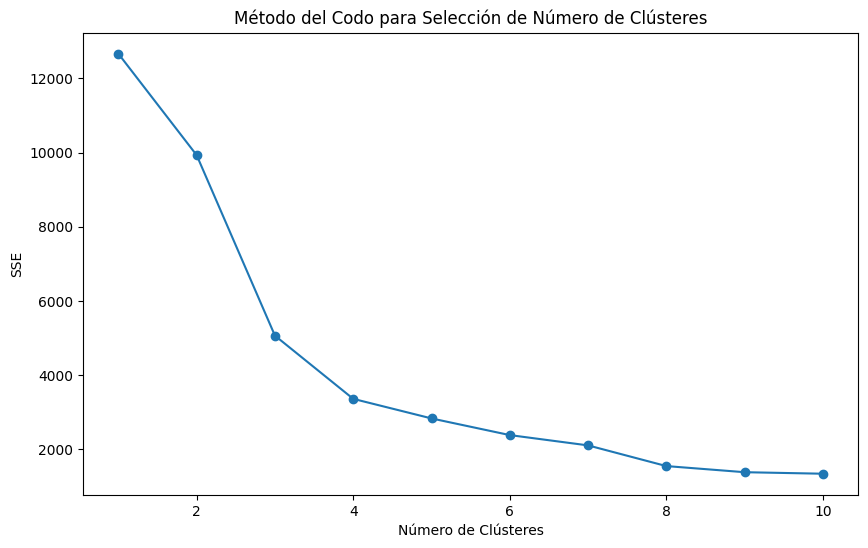

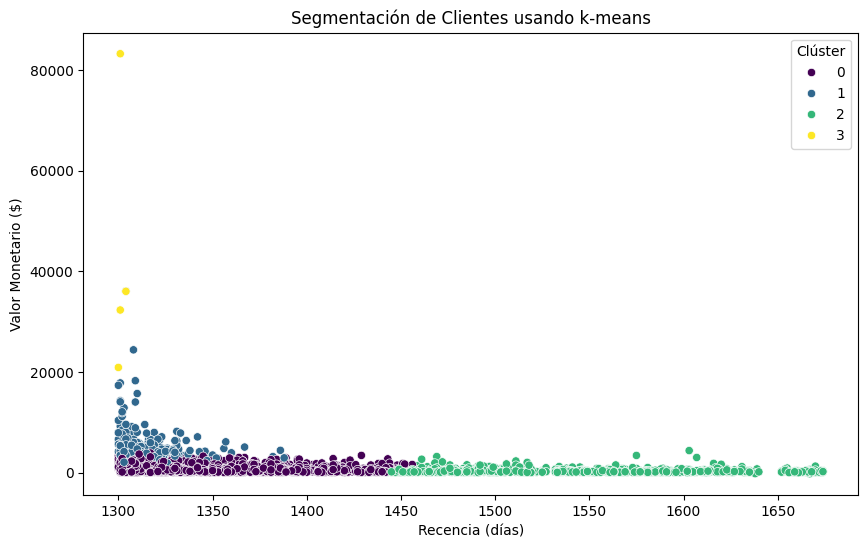

Cluster
0    2880
2    1045
1     292
3       4
Name: count, dtype: int64
        Recency         Frequency         Monetary               
           mean  median      mean  median     mean   median count
Cluster                                                          
0        1342.9  1332.0      63.1    44.0    798.8    560.8  2880
1        1313.7  1308.0     397.8   320.0   5094.1   4216.5   292
2        1548.7  1543.0      24.5    15.0    296.2    202.5  1045
3        1301.5  1301.0    5196.2  4526.5  43118.4  34162.8     4


In [92]:
# Normalizar los datos
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Método del codo para encontrar el número óptimo de clústeres
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Método del Codo para Selección de Número de Clústeres')
plt.xlabel('Número de Clústeres')
plt.ylabel('SSE')
plt.show()

# Aplicar k-means con el número óptimo de clústeres (supongamos k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_normalized)

# Visualizar los clústeres
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Segmentación de Clientes usando k-means')
plt.xlabel('Recencia (días)')
plt.ylabel('Valor Monetario ($)')
plt.legend(title='Clúster')
plt.show()

# Distribución de clientes por clúster
print(rfm_df['Cluster'].value_counts())

# Estadísticas descriptivas por clúster
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'count']
}).round(1)
print(cluster_summary)


Cluster Summary Sorted by Monetary Value:
          Recency  Frequency  Monetary
Cluster                              
2         1548.7       24.5     296.2
0         1342.9       63.1     798.8
1         1313.7      397.8    5094.1
3         1301.5     5196.2   43118.4


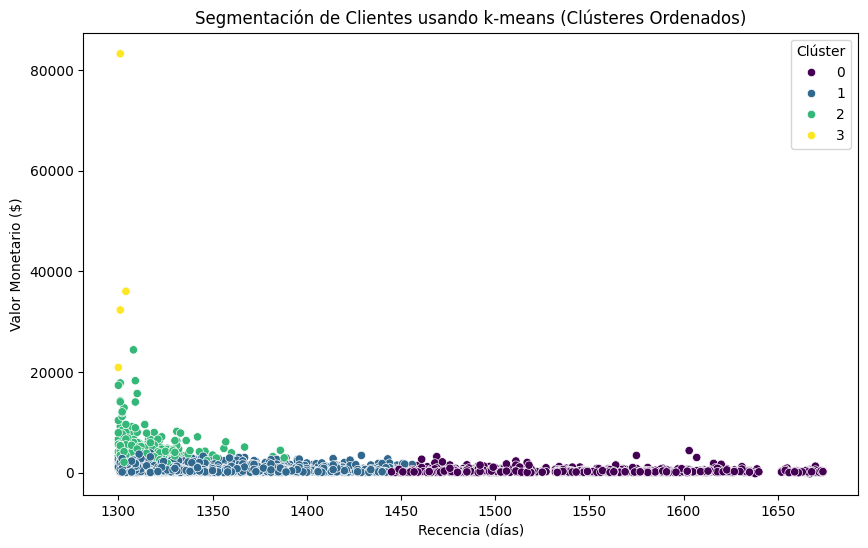

Cluster
1    2880
0    1045
2     292
3       4
Name: count, dtype: int64
Cluster Summary Ordered:
         Recency         Frequency         Monetary               
           mean  median      mean  median     mean   median count
Cluster                                                          
0        1548.7  1543.0      24.5    15.0    296.2    202.5  1045
1        1342.9  1332.0      63.1    44.0    798.8    560.8  2880
2        1313.7  1308.0     397.8   320.0   5094.1   4216.5   292
3        1301.5  1301.0    5196.2  4526.5  43118.4  34162.8     4


In [93]:
# Aplicar k-means con el número óptimo de clústeres k=4
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_normalized)

# Calcular estadísticas descriptivas por clúster
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)

# Ordenar los clústeres por valor monetario promedio
cluster_summary = cluster_summary.sort_values(by='Monetary')
print("Cluster Summary Sorted by Monetary Value:\n", cluster_summary)

# Crear un diccionario para mapear los clústeres originales a los nuevos clústeres ordenados
cluster_mapping = {old_cluster: new_cluster for new_cluster, old_cluster in enumerate(cluster_summary.index)}

# Reasignar los números de clústeres en el DataFrame original
rfm_df['Cluster'] = rfm_df['Cluster'].map(cluster_mapping)

# Visualizar los clústeres ordenados
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Segmentación de Clientes usando k-means (Clústeres Ordenados)')
plt.xlabel('Recencia (días)')
plt.ylabel('Valor Monetario ($)')
plt.legend(title='Clúster')
plt.show()

# Distribución de clientes por clúster ordenado
print(rfm_df['Cluster'].value_counts())

# Estadísticas descriptivas por clúster ordenado
cluster_summary_ordered = rfm_df.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'count']
}).round(1)
print("Cluster Summary Ordered:\n", cluster_summary_ordered)